In [1]:
# Colab: Install dependencies
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
from torchvision import datasets, transforms
from collections import defaultdict
import datetime
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler
import numpy as np
import random
import copy
import torch.nn as nn
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
import os
from google.colab import drive
from collections import defaultdict
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Configuration
class Config:
    DATASET = 'CIFAR100'
    MODEL_NAME = 'vit_small_patch16_224'
    BATCH_SIZE = 64
    NUM_CLIENTS = 20
    IID = True
    NC = 10  # Classes per client for non-IID
    VAL_SPLIT = 0.1
    EPOCHS_CENTRALIZED = 50
    EPOCHS_FEDAVG = 50
    LOCAL_EPOCHS = 5
    LR = 0.03
    MOMENTUM = 0.9
    WEIGHT_DECAY = 5e-4
    SPARSE_RATIO = 0.5
    CLIENT_FRACTION = 0.1

In [4]:
# Constants
NUM_CLASSES = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_PATH = '/content/drive/MyDrive/checkpoint.pth'

In [5]:
# Data Loading and Processing
def get_transforms():
    """Return train and test transformations for CIFAR-100"""
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
    ])
    return transform_train, transform_test

def split_dataset(dataset, val_split=0.1, seed=42):
    """Split dataset into training and validation subsets"""
    np.random.seed(seed)
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    val_size = int(len(dataset) * val_split)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

def iid_shard(dataset, num_clients):
    """Create IID partitions of the dataset"""
    data_per_client = len(dataset) // num_clients
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    return [indices[i*data_per_client:(i+1)*data_per_client] for i in range(num_clients)]

def noniid_shard(dataset, num_clients, nc=1):
    """Create non-IID partitions with nc classes per client"""
    # Handle both regular datasets and Subsets
    if isinstance(dataset, Subset):
        labels = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        labels = np.array(dataset.targets)

    num_classes = len(np.unique(labels))
    idx_by_class = [np.where(labels == i)[0] for i in range(num_classes)]
    client_indices = [[] for _ in range(num_clients)]
    classes_per_client = [np.random.choice(num_classes, nc, replace=False)
                         for _ in range(num_clients)]

    for client_id, client_classes in enumerate(classes_per_client):
        for c in client_classes:
            # Distribute samples equally among clients for each class
            cnt = len(idx_by_class[c]) // num_clients
            chosen = idx_by_class[c][:cnt]
            idx_by_class[c] = idx_by_class[c][cnt:]
            client_indices[client_id].extend(chosen.tolist())

    return client_indices

def get_dataloaders(config, iid=True, nc=10):
    """Create dataloaders for federated learning setup"""
    transform_train, transform_test = get_transforms()

    # Load datasets
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

    # Split into train and validation
    trainset, valset = split_dataset(trainset, val_split=config.VAL_SPLIT)

    # Create shards (IID or non-IID)
    shards = iid_shard(trainset, config.NUM_CLIENTS) if iid else noniid_shard(trainset, config.NUM_CLIENTS, nc)

    # Create client dataloaders
    clients_loaders = [
        DataLoader(
            trainset,
            batch_size=config.BATCH_SIZE,
            sampler=SubsetRandomSampler(idxs),
            num_workers=2,
            pin_memory=True
        ) for idxs in shards
    ]

    # Create validation and test dataloaders
    val_loader = DataLoader(
        valset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        testset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return clients_loaders, val_loader, test_loader

In [6]:
# Model Architecture
class ViTSmallDINO(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

def get_model(num_classes=100, device='cuda'):
    model = ViTSmallDINO(num_classes=num_classes)
    return model.to(device)

In [7]:
# Federated Learning Utilities
def average_weights(weights_list):
    avg = copy.deepcopy(weights_list[0])
    for key in avg.keys():
        for i in range(1, len(weights_list)):
            avg[key] += weights_list[i][key]
        avg[key] = torch.div(avg[key], len(weights_list))
    return avg

def fedavg_round(model, clients_loaders, config, mask=None, device='cuda'):
    selected_clients = random.sample(range(len(clients_loaders)), max(1, int(config.NUM_CLIENTS * config.CLIENT_FRACTION)))
    weights = []

    for client_idx in selected_clients:
        local_model = copy.deepcopy(model)
        optimizer = torch.optim.SGD(
            local_model.parameters(),
            lr=config.LR,
            momentum=config.MOMENTUM,
            weight_decay=config.WEIGHT_DECAY
        )
        criterion = nn.CrossEntropyLoss()

        for _ in range(config.LOCAL_EPOCHS):
            train(local_model, clients_loaders[client_idx], optimizer, criterion, device, mask)

        weights.append(copy.deepcopy(local_model.state_dict()))
        del local_model
        torch.cuda.empty_cache()

    model.load_state_dict(average_weights(weights))
    return model

In [8]:
# Model Editing Utilities
def fisher_sensitivity(model, dataloader, device, num_samples=128):
    model.eval()
    grads = []
    criterion = nn.CrossEntropyLoss()

    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        grads.append([p.grad.detach().clone() for p in model.parameters()])
        if i * x.size(0) >= num_samples:
            break

    return [(torch.stack(params) ** 2).mean(dim=0) for params in zip(*grads)]

def calibrate_mask(model, dataloader, device, method="least-sensitive", sparsity=0.2, seed=42):
    torch.manual_seed(seed)
    fisher = fisher_sensitivity(model, dataloader, device)
    mask = []

    for param_fisher in fisher:
        param_flat = param_fisher.view(-1)
        k = int(param_flat.numel() * sparsity)

        if method == "least-sensitive":
            idx = torch.topk(param_flat, k, largest=False).indices
        elif method == "most-sensitive":
            idx = torch.topk(param_flat, k, largest=True).indices
        elif method == "low-magnitude":
            idx = torch.topk(param_flat.abs(), k, largest=False).indices
        elif method == "high-magnitude":
            idx = torch.topk(param_flat.abs(), k, largest=True).indices
        elif method == "random":
            idx = torch.randperm(param_flat.numel())[:k]
        else:
            raise ValueError("Unknown method")

        m = torch.zeros_like(param_flat)
        m[idx] = 1
        mask.append(m.view(param_fisher.size()))

    return mask

def hybrid_mask(model, dataloader, device, sparsity=0.5, alpha=0.5):
    fisher = fisher_sensitivity(model, dataloader, device)
    magnitude = [p.abs().detach() for p in model.parameters()]
    hybrid_mask = []

    for f, m in zip(fisher, magnitude):
        score = alpha * f + (1 - alpha) * m
        k = int(score.numel() * sparsity)
        idx = torch.topk(score.view(-1), k, largest=False).indices
        m = torch.zeros_like(score.view(-1))
        m[idx] = 1
        hybrid_mask.append(m.view(score.size()))

    return hybrid_mask

class SparseSGDM(optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, weight_decay=0, mask=None):
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.mask = mask

    @torch.no_grad()
    def step(self, closure=None):
        loss = super().step(closure)
        if self.mask:
            for group in self.param_groups:
                for i, p in enumerate(group['params']):
                    if p.grad is not None and i < len(self.mask):
                        p.grad *= self.mask[i].to(p.grad.device)
        return loss

In [9]:
# Training and Evaluation
def train(model, loader, optimizer, criterion, device, mask=None):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()

        if mask is not None and isinstance(optimizer, SparseSGDM):
            optimizer.mask = mask

        optimizer.step()

        loss_sum += loss.item() * y.size(0)
        _, pred = outputs.max(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            loss_sum += loss.item() * y.size(0)
            _, pred = outputs.max(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    return loss_sum / total, correct / total

# Experiment Tracking
def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }, path)

def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    return checkpoint['epoch']

In [10]:
# Visualization
def plot_curves(train_loss, val_loss, train_acc, val_acc, save_path=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss', marker='o', markersize=3)
    plt.plot(val_loss, label='Val Loss', marker='o', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title("Loss Curves")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Acc', marker='o', markersize=3)
    plt.plot(val_acc, label='Val Acc', marker='o', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title("Accuracy Curves")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_conf_matrix(model, loader, class_names, device, normalize='true', save_path=None):
    y_true, y_pred = [], []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, preds = out.max(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues',
             values_format='.2f' if normalize else 'd')
    plt.title('Confusion Matrix')
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, loader, class_names, device, n=8, save_path=None):
    model.eval()
    images, labels, preds = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            images.append(x.cpu())
            labels.append(y.cpu())
            preds.append(pred.cpu())
            if len(images) * x.size(0) >= n:
                break

    images = torch.cat(images)[:n]
    labels = torch.cat(labels)[:n]
    preds = torch.cat(preds)[:n]

    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * np.array([0.2675, 0.2565, 0.2761])) + np.array([0.5071, 0.4867, 0.4408])
        img = np.clip(img, 0, 1)

        # Color coding for correct/incorrect predictions
        color = 'green' if labels[i] == preds[i] else 'red'
        plt.imshow(img)
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[preds[i]]}",
                  color=color)
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [11]:
# Experimental Routines
def run_centralized_training():
    drive.mount('/content/drive')
    config = Config()
    CHECKPOINT_PATH = '/content/drive/MyDrive/checkpoint1.pth'
    # Set seeds
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load data
    clients_loaders, val_loader, test_loader = get_dataloaders(config)
    class_names = [str(i) for i in range(NUM_CLASSES)]

    # Initialize model
    model = get_model(NUM_CLASSES, DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM, weight_decay=config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.EPOCHS_CENTRALIZED)
    criterion = nn.CrossEntropyLoss()

    # Track best model
    best_val_acc = 0
    best_model_state = None
    best_epoch = 0

    # Load checkpoint if exists
    if os.path.exists(CHECKPOINT_PATH):
        try:
            checkpoint = torch.load(CHECKPOINT_PATH)

            # Backward compatible loading
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1  # Start from next epoch

            # Ensure metrics exist in checkpoint
            train_losses = checkpoint.get('train_losses', [])
            val_losses = checkpoint.get('val_losses', [])
            train_accs = checkpoint.get('train_accs', [])
            val_accs = checkpoint.get('val_accs', [])

            # Load best model if available
            if 'best_model_state' in checkpoint and checkpoint['best_model_state'] is not None:
                best_model_state = checkpoint['best_model_state']
                best_val_acc = checkpoint.get('best_val_acc', 0)
                best_epoch = checkpoint.get('best_epoch', 0)

            print(f"Resumed from epoch {checkpoint['epoch']} with {len(train_losses)} metrics")
            print(f"Previous best val acc: {best_val_acc:.3f} at epoch {best_epoch}")

            # Verify metrics integrity
            if len(train_losses) != checkpoint['epoch'] + 1:
                print("Warning: Metric length mismatch! Initializing fresh metrics")
                train_losses, val_losses, train_accs, val_accs = [], [], [], []

        except Exception as e:
            print(f"Checkpoint load error: {e}. Starting fresh")
            start_epoch = 0
            train_losses, val_losses, train_accs, val_accs = [], [], [], []
    else:
        start_epoch = 0
        train_losses, val_losses, train_accs, val_accs = [], [], [], []
        print("No checkpoint found - starting new training")

    # Training loop
    for epoch in range(start_epoch, config.EPOCHS_CENTRALIZED):
        trl, tra = train(model, clients_loaders[0], optimizer, criterion, DEVICE)
        vall, vala = evaluate(model, val_loader, criterion, DEVICE)

        train_losses.append(trl)
        val_losses.append(vall)
        train_accs.append(tra)
        val_accs.append(vala)

        # Track best model
        if vala > best_val_acc:
            best_val_acc = vala
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"New best val acc: {best_val_acc:.3f} at epoch {best_epoch}")

        scheduler.step()
        print(f"Epoch {epoch}: Train Loss {trl:.4f}, Val Loss {vall:.4f} | "
              f"Train Acc {tra:.3f}, Val Acc {vala:.3f}")

        # Enhanced checkpoint saving
        torch.save({
            'version': 3.0,  # Version identifier
            'epoch': epoch,
            'best_epoch': best_epoch,
            'best_val_acc': best_val_acc,
            'model_state_dict': model.state_dict(),
            'best_model_state': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
        }, CHECKPOINT_PATH)

    # Load best model for final evaluation only if it exists
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    tloss, tacc = evaluate(model, test_loader, criterion, DEVICE)
    print(f"\n=== Best Model Results ===")
    print(f"Best Val Acc: {best_val_acc:.3f} at epoch {best_epoch}")
    print(f"Final Test Accuracy: {tacc:.3f}")

    # Visualizations
    plot_curves(train_losses, val_losses, train_accs, val_accs,
               save_path='training_curves.png')
    plot_conf_matrix(model, test_loader, class_names, DEVICE,
                   save_path='confusion_matrix.png')
    visualize_predictions(model, test_loader, class_names, DEVICE, n=8,
                        save_path='predictions.png')

    return model, train_losses, val_losses, train_accs, val_accs

def run_fedavg_experiments():
    CHECKPOINT_DIR = '/content/drive/MyDrive/fedavg_checkpoints'  # Directory for all checkpoints
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)  # Create directory if it doesn't exist

    config = Config()
    nc_values = [1, 5, 10, 50]  # Number of classes per client
    local_epochs_values = [1, 4, 8]  # More reasonable local epochs range
    results = defaultdict(dict)

    # Track best performing configuration
    best_acc = 0
    best_config = {}

    # Load data - ensure non-IID for federated setting
    clients_loaders, val_loader, test_loader = get_dataloaders(config, iid=False, nc=config.NC)
    criterion = nn.CrossEntropyLoss()

    for nc in nc_values:
        for local_epochs in local_epochs_values:
            print(f"\n=== Running FedAvg with nc={nc}, local_epochs={local_epochs} ===")

            # Create unique checkpoint path for this configuration
            checkpoint_path = os.path.join(
                CHECKPOINT_DIR,
                f'fedavg_nc{nc}_le{local_epochs}.pth'
            )

            # Initialize model and optimizer
            model = get_model(NUM_CLASSES, DEVICE)
            optimizer = optim.SGD(model.parameters(),
                                lr=config.LR,
                                momentum=config.MOMENTUM,
                                weight_decay=config.WEIGHT_DECAY)

            # Resume if checkpoint exists
            start_round = 0
            if os.path.exists(checkpoint_path):
                try:
                    checkpoint = torch.load(checkpoint_path)
                    # Verify checkpoint contents
                    required_keys = ['round', 'model_state', 'optimizer_state', 'config', 'val_acc']
                    if all(key in checkpoint for key in required_keys):
                        model.load_state_dict(checkpoint['model_state'])
                        optimizer.load_state_dict(checkpoint['optimizer_state'])
                        start_round = checkpoint['round'] + 1
                        print(f"Resumed training from round {start_round}")
                        print(f"Previous validation accuracy: {checkpoint['val_acc']:.4f}")
                    else:
                        print("Checkpoint missing required keys. Starting fresh.")
                except Exception as e:
                    print(f"Error loading checkpoint: {str(e)}. Starting fresh.")

            # Federated training loop
            for r in range(start_round, config.EPOCHS_FEDAVG):
                # Select clients for this round
                selected_clients = np.random.choice(
                    len(clients_loaders),
                    size=max(1, int(config.CLIENT_FRACTION * len(clients_loaders))),
                    replace=False
                )

                # Train on selected clients
                client_models = []
                for client_idx in selected_clients:
                    client_model = copy.deepcopy(model)
                    client_optimizer = optim.SGD(client_model.parameters(),
                                               lr=config.LR,
                                               momentum=config.MOMENTUM)

                    # Local training
                    for _ in range(local_epochs):
                        train(client_model, clients_loaders[client_idx],
                             client_optimizer, criterion, DEVICE)

                    client_models.append(client_model)

                # Aggregate models (FedAvg)
                with torch.no_grad():
                    for param in model.parameters():
                        param.data.zero_()

                    for client_model in client_models:
                        for server_param, client_param in zip(model.parameters(),
                                                           client_model.parameters()):
                            server_param.data += client_param.data / len(selected_clients)

                # Validation and checkpointing
                if (r + 1) % 5 == 0 or r == config.EPOCHS_FEDAVG - 1:
                    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
                    print(f"Round {r+1}/{config.EPOCHS_FEDAVG}: Val Acc {val_acc:.4f}")

                    # Save checkpoint with all necessary information
                    try:
                        torch.save({
                            'round': r,
                            'model_state': model.state_dict(),
                            'optimizer_state': optimizer.state_dict(),
                            'config': {
                                'nc': nc,
                                'local_epochs': local_epochs,
                                'lr': config.LR,
                                'momentum': config.MOMENTUM
                            },
                            'val_acc': val_acc,
                            'timestamp': datetime.datetime.now().isoformat()
                        }, checkpoint_path)
                    except Exception as e:
                        print(f"Error saving checkpoint: {str(e)}")

            # Final evaluation
            test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
            results[nc][local_epochs] = test_acc

            # Track best configuration
            if test_acc > best_acc:
                best_acc = test_acc
                best_config = {'nc': nc, 'local_epochs': local_epochs}

            print(f"\nFinal Test Accuracy for nc={nc}, local_epochs={local_epochs}: {test_acc:.4f}")
            print("="*50)

    # Print summary
    print("\n=== Experiment Summary ===")
    print(f"Best Configuration: {best_config} with accuracy {best_acc:.4f}")
    print("Full Results:")
    for nc, acc_dict in results.items():
        for le, acc in acc_dict.items():
            print(f"nc={nc}, local_epochs={le}: {acc:.4f}")

    return results

# ---------- Sparse Training Experiments ----------
def run_sparse_experiments():
    config = Config()
    methods = ['least-sensitive', 'most-sensitive', 'low-magnitude', 'high-magnitude', 'random', 'hybrid']
    sparsity_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    # Create dedicated checkpoint directory for sparse experiments
    SPARSE_CHECKPOINT_DIR = "/content/drive/MyDrive/sparse_checkpoints"
    os.makedirs(SPARSE_CHECKPOINT_DIR, exist_ok=True)

    clients_loaders, val_loader, test_loader = get_dataloaders(config)
    criterion = nn.CrossEntropyLoss()

    for method in methods:
        # Create subdirectory for each method
        method_dir = os.path.join(SPARSE_CHECKPOINT_DIR, method)
        os.makedirs(method_dir, exist_ok=True)

        for sparsity in sparsity_ratios:
            print(f"\nMethod: {method}, Sparsity: {sparsity}")
            ckpt_path = os.path.join(method_dir, f"sparsity_{sparsity}.pt")

            model = get_model(NUM_CLASSES, DEVICE)

            # Select mask function with correct arguments
            if method == 'hybrid':
                mask = hybrid_mask(model, clients_loaders[0], DEVICE, sparsity=sparsity, alpha=0.5)
            else:
                mask = calibrate_mask(model, clients_loaders[0], DEVICE, method=method, sparsity=sparsity)

            optimizer = SparseSGDM(model.parameters(), lr=config.LR, momentum=config.MOMENTUM,
                                 weight_decay=config.WEIGHT_DECAY, mask=mask)

            start_epoch = 0
            if os.path.exists(ckpt_path):
                start_epoch = load_checkpoint(model, optimizer, ckpt_path, DEVICE)
                print(f"Resumed from epoch {start_epoch}")

            for epoch in range(start_epoch, 5):
                trl, tra = train(model, clients_loaders[0], optimizer, criterion, DEVICE)
                vall, vala = evaluate(model, val_loader, criterion, DEVICE)
                print(f"Epoch {epoch}: Train Acc {tra:.3f}, Val Acc {vala:.3f}")
                save_checkpoint(model, optimizer, epoch, ckpt_path)

            tloss, tacc = evaluate(model, test_loader, criterion, DEVICE)
            print(f"Test Accuracy for method {method}, sparsity {sparsity}: {tacc:.3f}")
            results.append({'method': method, 'sparsity': sparsity, 'accuracy': tacc})

    return results


# ---------- Mask Overlap Analysis ----------
def analyze_mask_overlap():
    config = Config()

    # Create dedicated checkpoint directory for mask analysis
    MASK_CHECKPOINT_DIR = '/content/drive/MyDrive/mask_checkpoints'
    os.makedirs(MASK_CHECKPOINT_DIR, exist_ok=True)

    clients_loaders, val_loader, _ = get_dataloaders(config, iid=False, nc=config.NC)
    model = get_model(NUM_CLASSES, DEVICE)

    methods = ['least-sensitive', 'most-sensitive', 'low-magnitude', 'high-magnitude', 'random', 'hybrid']
    SPARSE_RATIO = [0.1, 0.3, 0.5, 0.7, 0.9]

    results = []
    layer_similarities = {}
    similarity_matrix = np.zeros((5, 5))  # Assuming 5 clients

    for method in methods:
        # Create subdirectory for each method
        method_dir = os.path.join(MASK_CHECKPOINT_DIR, method)
        os.makedirs(method_dir, exist_ok=True)

        for sparsity in SPARSE_RATIO:
            print(f"\nMethod: {method}, Sparsity: {sparsity}")
            ckpt_path = os.path.join(method_dir, f"sparsity_{sparsity}.pt")

            model = get_model(NUM_CLASSES, DEVICE)

            # Fill in the proper arguments for mask computation
            if method == 'hybrid':
                mask = hybrid_mask(model, clients_loaders[0], DEVICE, sparsity=sparsity, alpha=0.5)
            else:
                mask = calibrate_mask(model, clients_loaders[0], DEVICE, method=method, sparsity=sparsity)

            optimizer = SparseSGDM(model.parameters(), lr=config.LR, momentum=config.MOMENTUM,
                                 weight_decay=config.WEIGHT_DECAY, mask=mask)

            start_epoch = 0
            if os.path.exists(ckpt_path):
                start_epoch = load_checkpoint(model, optimizer, ckpt_path, DEVICE)
                print(f"Resumed from epoch {start_epoch}")

            for epoch in range(start_epoch, 5):
                trl, tra = train(model, clients_loaders[0], optimizer, nn.CrossEntropyLoss(), DEVICE)
                vall, vala = evaluate(model, val_loader, nn.CrossEntropyLoss(), DEVICE)
                print(f"Epoch {epoch}: Train Acc {tra:.3f}, Val Acc {vala:.3f}")
                save_checkpoint(model, optimizer, epoch, ckpt_path)

    # Optionally return or save results
    return results


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No checkpoint found - starting new training
New best val acc: 0.014 at epoch 0
Epoch 0: Train Loss 4.8048, Val Loss 4.6325 | Train Acc 0.009, Val Acc 0.014
New best val acc: 0.024 at epoch 1
Epoch 1: Train Loss 4.5950, Val Loss 4.4943 | Train Acc 0.024, Val Acc 0.024
New best val acc: 0.047 at epoch 2
Epoch 2: Train Loss 4.2887, Val Loss 4.3065 | Train Acc 0.051, Val Acc 0.047
New best val acc: 0.085 at epoch 3
Epoch 3: Train Loss 4.0438, Val Loss 4.0310 | Train Acc 0.088, Val Acc 0.085
New best val acc: 0.099 at epoch 4
Epoch 4: Train Loss 3.7096, Val Loss 4.0760 | Train Acc 0.122, Val Acc 0.099
New best val acc: 0.154 at epoch 5
Epoch 5: Train Loss 3.4321, Val Loss 3.7545 | Train Acc 0.161, Val Acc 0.154
New best val acc: 0.200 at epoch 6
Epoch 6: Train Loss 2.9388, Val Loss 3.3539 | Train Acc 0.270, Val Acc 0.200
New best val acc: 0.244 at epoch 7
Epoch 7:

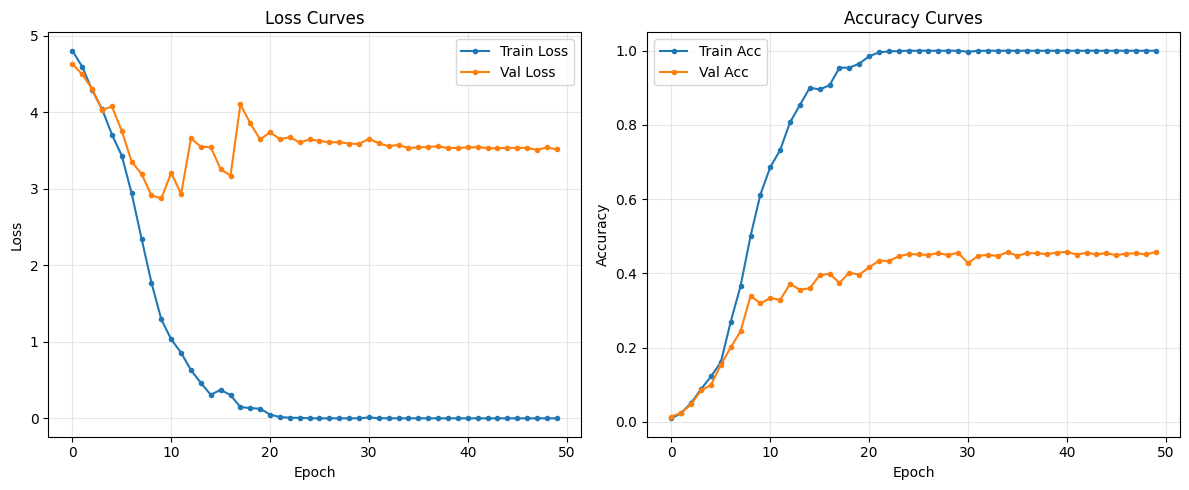

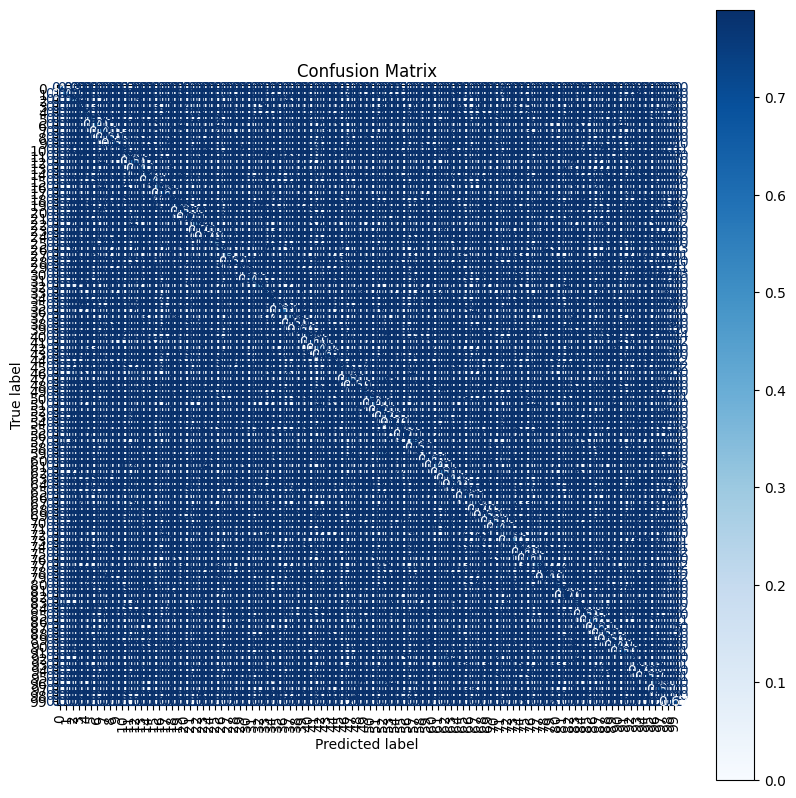

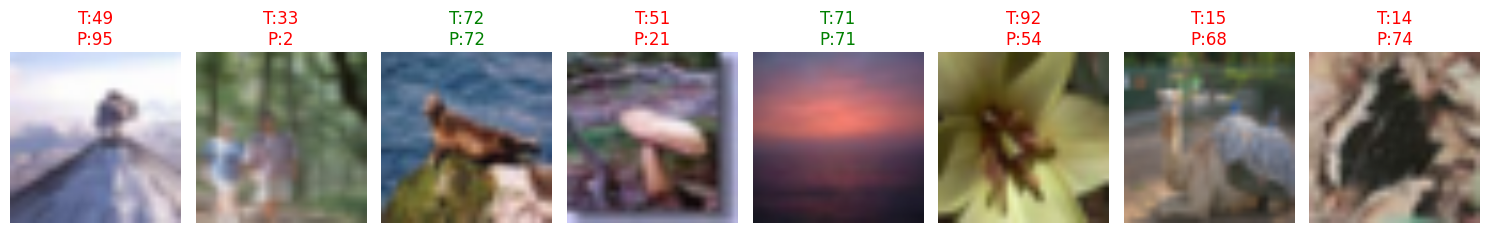

(ViTSmallDINO(
   (backbone): VisionTransformer(
     (patch_embed): PatchEmbed(
       (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
       (norm): Identity()
     )
     (pos_drop): Dropout(p=0.0, inplace=False)
     (patch_drop): Identity()
     (norm_pre): Identity()
     (blocks): Sequential(
       (0): Block(
         (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
         (attn): Attention(
           (qkv): Linear(in_features=384, out_features=1152, bias=True)
           (q_norm): Identity()
           (k_norm): Identity()
           (attn_drop): Dropout(p=0.0, inplace=False)
           (proj): Linear(in_features=384, out_features=384, bias=True)
           (proj_drop): Dropout(p=0.0, inplace=False)
         )
         (ls1): Identity()
         (drop_path1): Identity()
         (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
         (mlp): Mlp(
           (fc1): Linear(in_features=384, out_features=1536, bias=True)
           (a

In [ ]:
run_centralized_training()

In [ ]:
run_fedavg_experiments()


=== Running FedAvg with nc=1, local_epochs=1 ===
Checkpoint load error: 'config'. Starting fresh
Round 5/50: Val Acc 0.1804
Round 10/50: Val Acc 0.3288
Round 15/50: Val Acc 0.4630
Round 20/50: Val Acc 0.5108
Round 25/50: Val Acc 0.5904
Round 30/50: Val Acc 0.6282
Round 35/50: Val Acc 0.6330
Round 40/50: Val Acc 0.6654
Round 45/50: Val Acc 0.6588
Round 50/50: Val Acc 0.6776

Final Test Accuracy for nc=1, local_epochs=1: 0.6847

=== Running FedAvg with nc=1, local_epochs=4 ===
Checkpoint config mismatch, starting fresh
Round 5/50: Val Acc 0.1578
Round 10/50: Val Acc 0.2806
Round 15/50: Val Acc 0.3272
Round 20/50: Val Acc 0.3436
Round 25/50: Val Acc 0.3980
Round 30/50: Val Acc 0.3862
Round 35/50: Val Acc 0.4878
Round 40/50: Val Acc 0.5280
Round 45/50: Val Acc 0.4636
Round 50/50: Val Acc 0.5018

Final Test Accuracy for nc=1, local_epochs=4: 0.5115

=== Running FedAvg with nc=1, local_epochs=8 ===
Checkpoint config mismatch, starting fresh
Round 5/50: Val Acc 0.1548
Round 10/50: Val Acc 0.

In [ ]:
run_fedavg_experiments()


=== Running FedAvg with nc=1, local_epochs=1 ===


Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above ex

Round 5/50: Val Acc 0.1304
Round 10/50: Val Acc 0.2572
Round 15/50: Val Acc 0.2880
Round 20/50: Val Acc 0.3412
Round 25/50: Val Acc 0.4164
Round 30/50: Val Acc 0.4418
Round 35/50: Val Acc 0.5026
Round 40/50: Val Acc 0.5354
Round 45/50: Val Acc 0.4862
Round 50/50: Val Acc 0.5340

Final Test Accuracy for nc=1, local_epochs=1: 0.5453

=== Running FedAvg with nc=1, local_epochs=4 ===
Round 5/50: Val Acc 0.0206
Round 10/50: Val Acc 0.0124
Round 15/50: Val Acc 0.0174
Round 20/50: Val Acc 0.0298
Round 25/50: Val Acc 0.0436
Round 30/50: Val Acc 0.0346
Round 35/50: Val Acc 0.0412
Round 40/50: Val Acc 0.0354
Round 45/50: Val Acc 0.0336
Round 50/50: Val Acc 0.0254

Final Test Accuracy for nc=1, local_epochs=4: 0.0240

=== Running FedAvg with nc=1, local_epochs=8 ===
Round 5/50: Val Acc 0.0092
Round 10/50: Val Acc 0.0096
Round 15/50: Val Acc 0.0256
Round 20/50: Val Acc 0.0218
Round 25/50: Val Acc 0.0240
Round 30/50: Val Acc 0.0184
Round 35/50: Val Acc 0.0146
Round 40/50: Val Acc 0.0196
Round 45/50

In [ ]:
run_fedavg_experiments()

100%|██████████| 169M/169M [00:05<00:00, 31.3MB/s]



=== Running FedAvg with nc=1, local_epochs=1 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Resumed training from round 50
Previous validation accuracy: 0.5340

Final Test Accuracy for nc=1, local_epochs=1: 0.5453

=== Running FedAvg with nc=1, local_epochs=4 ===
Resumed training from round 50
Previous validation accuracy: 0.0254

Final Test Accuracy for nc=1, local_epochs=4: 0.0240

=== Running FedAvg with nc=1, local_epochs=8 ===
Round 5/50: Val Acc 0.0116
Round 10/50: Val Acc 0.0104
Round 15/50: Val Acc 0.0100
Round 20/50: Val Acc 0.0108
Round 25/50: Val Acc 0.0084
Round 30/50: Val Acc 0.0092
Round 35/50: Val Acc 0.0078
Round 40/50: Val Acc 0.0080
Round 45/50: Val Acc 0.0170
Round 50/50: Val Acc 0.0114

Final Test Accuracy for nc=1, local_epochs=8: 0.0117

=== Running FedAvg with nc=5, local_epochs=1 ===
Round 5/50: Val Acc 0.0848
Round 10/50: Val Acc 0.0500
Round 15/50: Val Acc 0.2320
Round 20/50: Val Acc 0.3030
Round 25/50: Val Acc 0.3842
Round 30/50: Val Acc 0.3902
Round 35/50: Val Acc 0.4700
Round 40/50: Val Acc 0.4930
Round 45/50: Val Acc 0.4516
Round 50/50: Val Acc 0

In [ ]:
run_fedavg_experiments()

100%|██████████| 169M/169M [00:04<00:00, 41.7MB/s]



=== Running FedAvg with nc=1, local_epochs=1 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Resumed training from round 50
Previous validation accuracy: 0.5340

Final Test Accuracy for nc=1, local_epochs=1: 0.5453

=== Running FedAvg with nc=1, local_epochs=4 ===
Resumed training from round 50
Previous validation accuracy: 0.0254

Final Test Accuracy for nc=1, local_epochs=4: 0.0240

=== Running FedAvg with nc=1, local_epochs=8 ===
Resumed training from round 50
Previous validation accuracy: 0.0114

Final Test Accuracy for nc=1, local_epochs=8: 0.0117

=== Running FedAvg with nc=5, local_epochs=1 ===
Resumed training from round 50
Previous validation accuracy: 0.5252

Final Test Accuracy for nc=5, local_epochs=1: 0.5306

=== Running FedAvg with nc=5, local_epochs=4 ===
Resumed training from round 50
Previous validation accuracy: 0.0208

Final Test Accuracy for nc=5, local_epochs=4: 0.0196

=== Running FedAvg with nc=5, local_epochs=8 ===
Resumed training from round 40
Previous validation accuracy: 0.0218
Round 45/50: Val Acc 0.0192
Round 50/50: Val Acc 0.0130

Final Test Accu

In [ ]:
run_sparse_experiments()


Method: least-sensitive, Sparsity: 0.1
Resumed from epoch 4
Epoch 4: Train Acc 0.810, Val Acc 0.433
Test Accuracy for method least-sensitive, sparsity 0.1: 0.438

Method: least-sensitive, Sparsity: 0.3
Resumed from epoch 4
Epoch 4: Train Acc 0.817, Val Acc 0.452
Test Accuracy for method least-sensitive, sparsity 0.3: 0.464

Method: least-sensitive, Sparsity: 0.5
Resumed from epoch 4
Epoch 4: Train Acc 0.829, Val Acc 0.474
Test Accuracy for method least-sensitive, sparsity 0.5: 0.478

Method: least-sensitive, Sparsity: 0.7
Resumed from epoch 4
Epoch 4: Train Acc 0.864, Val Acc 0.494
Test Accuracy for method least-sensitive, sparsity 0.7: 0.495

Method: least-sensitive, Sparsity: 0.9
Resumed from epoch 4
Epoch 4: Train Acc 0.824, Val Acc 0.436
Test Accuracy for method least-sensitive, sparsity 0.9: 0.440

Method: most-sensitive, Sparsity: 0.1
Resumed from epoch 4
Epoch 4: Train Acc 0.805, Val Acc 0.425
Test Accuracy for method most-sensitive, sparsity 0.1: 0.438

Method: most-sensitive,

[{'method': 'least-sensitive', 'sparsity': 0.1, 'accuracy': 0.438},
 {'method': 'least-sensitive', 'sparsity': 0.3, 'accuracy': 0.4635},
 {'method': 'least-sensitive', 'sparsity': 0.5, 'accuracy': 0.4778},
 {'method': 'least-sensitive', 'sparsity': 0.7, 'accuracy': 0.4947},
 {'method': 'least-sensitive', 'sparsity': 0.9, 'accuracy': 0.4396},
 {'method': 'most-sensitive', 'sparsity': 0.1, 'accuracy': 0.4381},
 {'method': 'most-sensitive', 'sparsity': 0.3, 'accuracy': 0.4508},
 {'method': 'most-sensitive', 'sparsity': 0.5, 'accuracy': 0.4541},
 {'method': 'most-sensitive', 'sparsity': 0.7, 'accuracy': 0.438},
 {'method': 'most-sensitive', 'sparsity': 0.9, 'accuracy': 0.4384},
 {'method': 'low-magnitude', 'sparsity': 0.1, 'accuracy': 0.4289},
 {'method': 'low-magnitude', 'sparsity': 0.3, 'accuracy': 0.4707},
 {'method': 'low-magnitude', 'sparsity': 0.5, 'accuracy': 0.4152},
 {'method': 'low-magnitude', 'sparsity': 0.7, 'accuracy': 0.4385},
 {'method': 'low-magnitude', 'sparsity': 0.9, 'ac

In [ ]:
analyze_mask_overlap()

100%|██████████| 169M/169M [00:05<00:00, 30.8MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]


Method: least-sensitive, Sparsity: 0.1
Resumed from epoch 4
Epoch 4: Train Acc 0.146, Val Acc 0.011

Method: least-sensitive, Sparsity: 0.3
Resumed from epoch 4
Epoch 4: Train Acc 0.110, Val Acc 0.010

Method: least-sensitive, Sparsity: 0.5
Resumed from epoch 4
Epoch 4: Train Acc 0.123, Val Acc 0.009

Method: least-sensitive, Sparsity: 0.7
Resumed from epoch 4
Epoch 4: Train Acc 0.110, Val Acc 0.010

Method: least-sensitive, Sparsity: 0.9
Resumed from epoch 0
Epoch 0: Train Acc 0.315, Val Acc 0.010
Epoch 1: Train Acc 0.119, Val Acc 0.010
Epoch 2: Train Acc 0.100, Val Acc 0.010
Epoch 3: Train Acc 0.123, Val Acc 0.009
Epoch 4: Train Acc 0.105, Val Acc 0.012

Method: most-sensitive, Sparsity: 0.1
Epoch 0: Train Acc 0.384, Val Acc 0.051
Epoch 1: Train Acc 0.288, Val Acc 0.010
Epoch 2: Train Acc 0.082, Val Acc 0.010
Epoch 3: Train Acc 0.091, Val Acc 0.010
Epoch 4: Train Acc 0.105, Val Acc 0.012

Method: most-sensitive, Sparsity: 0.3
Epoch 0: Train Acc 0.384, Val Acc 0.051
Epoch 1: Train Ac

[]